In [29]:
import importlib
import os
import xarray as xr
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from datetime import datetime # for 
from shapely.geometry import Point

dir = os.getcwd()
os.chdir("/home/clueken/master/open_data")
import open_data_utils
importlib.reload(open_data_utils)
from open_data_utils import add_world_map, avg_by_time#import the module here, so that it can be reloaded.
os.chdir(dir)

## How to get data from file

In [5]:
#print(os.listdir("/mnt/data/users/eschoema/ObsPack_CO2_GLOBALVIEWplusv7.0/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc/"))
os.chdir("/mnt/data/users/eschoema/ObsPack_CO2_GLOBALVIEWplusv7.0")
file = 'obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc/co2_chl_surface-insitu_6_allvalid.nc'

dataset = xr.open_mfdataset(file, combine='by_coords',concat_dim='None')
#dataset.value_std_dev.values

array([3.500e-09, 1.093e-07, 8.060e-08, ..., 3.150e-07, 9.130e-08,
       6.387e-07], dtype=float32)

## Get and filter data for Australia

In [3]:
save = False
filter_for = "tower"
file_dir = '/mnt/data/users/eschoema/ObsPack_CO2_GLOBALVIEWplusv7.0/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc'
f = os.listdir(file_dir)

filenames = []
for file in f:
    filenames.append(file) if filter_for in file else None

filenames = filenames

#fig1, ax1 = plt.subplots(figsize=(10, 7))
#fig2, ax2 = plt.subplots(figsize=(10, 7))

#fig1, ax1 = add_world_map(fig1, ax1, color="gray", alpha=0.5, edgecolor="black")
names = []
geometry = []

for i,f in enumerate(filenames):
    file = os.path.join(file_dir, f)
    dataset = xr.open_mfdataset(file, combine='by_coords',concat_dim='None')
    geometry.append(Point([dataset.longitude.values[0], dataset.latitude.values[0]]))
    names.append(file)

df = pd.DataFrame(names, columns=["Filenames"])
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
austr = world[world.name == "Australia"]

gdf_austr = sjoin(gdf, austr)

if save: 
    np.savetxt(f"/home/clueken/master/open_data/data/obspack_austr_{filter_for}.txt", np.array(gdf_austr.Filenames.values), fmt="%s")

## Plot positions and measurements of measurements in Australia

No data for type aircraft in /home/clueken/master/open_data/data/obspack_austr_aircraft.txt
No data for type tower in /home/clueken/master/open_data/data/obspack_austr_tower.txt


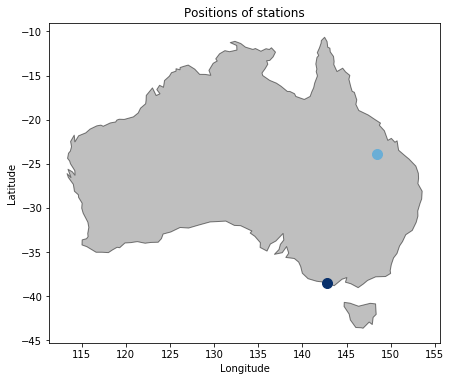

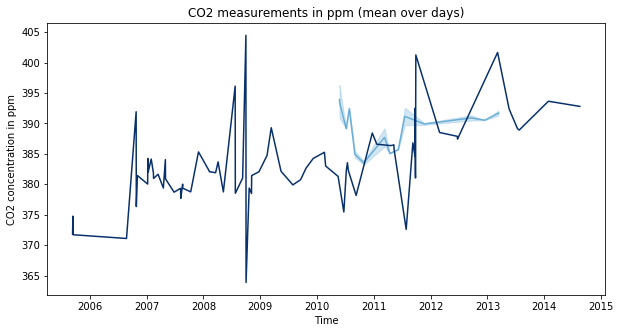

In [31]:
colors = ["blue", "red", "green"]
cmaps = ["Blues", "Reds", "Greens"]
types = ["surface", "aircraft", "tower"]
clip = [350, 430]
mean = "days"
err_mode = "std_dev"

fig1, ax1 = plt.subplots(figsize=(7, 7))
fig2, ax2 = plt.subplots(figsize=(10, 5))

ax1.set_title("Positions of stations")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")

ax2.set_title(f"CO2 measurements in ppm (mean over {mean})")
ax2.set_xlabel("Time")
ax2.set_ylabel("CO2 concentration in ppm")

mean_dict = dict(years=1, months=2, days=3, hours=4, minutes=5, seconds=6)
mean_ind = mean_dict[mean]

for i,key in enumerate(types):
        
    with open(f"/home/clueken/master/open_data/data/obspack_austr_{key}.txt") as f:
        filenames = f.read().splitlines()
    if len(filenames) == 0:
        print(f"No data for type {key} in /home/clueken/master/open_data/data/obspack_austr_{key}.txt")
        continue
    colors = cm.get_cmap(cmaps[i])(np.linspace(0.5, 1, len(filenames)))
    
    fig1, ax1 = add_world_map(fig1, ax1, country="Australia", color="gray", alpha=0.5, edgecolor="black")
    
    for j, f in enumerate(filenames):
        dataset = xr.open_mfdataset(f, combine='by_coords',concat_dim='None')
        assert len(np.unique(dataset.longitude)) == 1, f"Measurements for {f} are at different positions."
        ax1.scatter(dataset.longitude[0], dataset.latitude[0], color=colors[j], s=100)
        values, errors, times = avg_by_time(dataset, mean_ind, err_mode)
        values = values*1e6        
        errors = errors*1e6
        times = times[(clip[0] < values) * (values < clip[1])] if clip is not None else times
        values = values[(clip[0] < values) * (values < clip[1])] if clip is not None else values
        try:
            ax2.fill_between(times, values-errors, values+errors, alpha=0.3, color=colors[j])
        except:
            None 
        ax2.plot(times, values, color=colors[j])
#ax2.set_xlim(np.datetime64('2011-01-01'))
#plt.show()

## Get info of measurements in Australia

In [5]:
types = ["surface", "aircraft", "tower"]

for i,key in enumerate(types):
    with open(f"/home/clueken/master/open_data/data/obspack_austr_{key}.txt") as f:
        filenames = f.read().splitlines()
    print(f"Datasets for {key}-measurements:")
    for j, f in enumerate(filenames):

        dataset = xr.open_mfdataset(f, combine='by_coords',concat_dim='None')
        print(f"Filename: {f}")
        print(dataset)


Datasets for surface-measurements:
Filename: /mnt/data/users/eschoema/ObsPack_CO2_GLOBALVIEWplusv7.0/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc/co2_ara_surface-flask_2_representative.nc
<xarray.Dataset>
Dimensions:                     (calendar_components: 6, dim_concerns: 6, mip_nmodels: 17, obs: 30)
Dimensions without coordinates: calendar_components, dim_concerns, mip_nmodels, obs
Data variables:
    time                        (obs) datetime64[ns] dask.array<chunksize=(30,), meta=np.ndarray>
    start_time                  (obs) datetime64[ns] dask.array<chunksize=(30,), meta=np.ndarray>
    midpoint_time               (obs) datetime64[ns] dask.array<chunksize=(30,), meta=np.ndarray>
    datetime                    (obs) |S100 dask.array<chunksize=(30,), meta=np.ndarray>
    time_decimal                (obs) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    time_components             (obs, calendar_components) float64 dask.array<chunksize=(30, 6), meta=np.ndarray>

## Cells for other testing

In [12]:
dataset = xr.open_mfdataset("/mnt/data/users/eschoema/ObsPack_CO2_GLOBALVIEWplusv7.0/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc/co2_ota_surface-flask_2_representative.nc", combine='by_coords',concat_dim='None')
dataset.nvalue.values

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [32]:
#os.chdir("/mnt/data/users/eschoema/ObsPack_CO2_GLOBALVIEWplusv7.0")
file = '/mnt/data/users/eschoema/ObsPack_CO2_GLOBALVIEWplusv7.0/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc/co2_chl_surface-insitu_6_allvalid.nc'

dataset = xr.open_mfdataset(file, combine='by_coords',concat_dim='None')
v,e,t = avg_by_time(dataset,3, err_mode="std_dev")



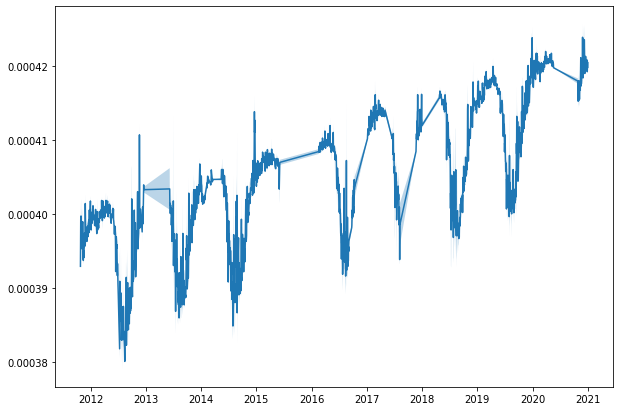

In [35]:
plt.figure(figsize=(10,7))
plt.plot(t,v)
plt.fill_between(t,v-e,v+e, alpha=.3)